In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
import numpy as np
from numpy import absolute, mean, std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data 
file_path = 'capstone.xlsx'
def getData(file_path):
    df = pd.read_excel (file_path)
    ingredList = ['CB std (N-234)', 'GNP sample', 'Production Run time', ]
    # mixer: 12-18, hightemp: 12 18
    propList = ['300% Modulus ,Mpa', 'Tensile, MPa', 'Elongation, %', 'Durometer, Shore A', 'Tan d max @ 5%']

    ingdf=df.loc[df['PAR921'].isin(ingredList)].iloc[:,2:20]
    ingArr=np.asarray(ingdf)

    propdf=df.loc[df['PAR921'].isin(propList)].iloc[:,2:20]
    propArr = np.zeros((6,18))
    propArr[0:5,:]=np.asarray(propdf)

    # calc abrasion resistance
    dG_row_over_dG_post_cure_row=df.iloc[134-2, 2::]/df.iloc[151-2, 2::]
    reinfroce_index_value=df.iloc[101-2, 2::]/df.iloc[100-2, 2::]
    hardness_row=df.iloc[106-2, 2::]
    # print(reinfroce_index_value[0], reinfroce_index_value**2)
    dG_row_over_dG_post_cure_row
    mid_equal = hardness_row/ ((dG_row_over_dG_post_cure_row**0.5)*(reinfroce_index_value**2))
    abrasion=mid_equal*0.0396 -1.6907
    abrasion_row = np.asarray(abrasion.iloc[0:18])
    propArr[5] = abrasion_row

    # add temp and mixer in (0,1), [3]high temp is 1 [4]1.6L mixer is also 1
    ingActArr = np.zeros((5,18))
    ingActArr[0:3,:]=ingArr
    ingActArr[3, 11:18]=1
    ingActArr[4,11]=1
    ingActArr[4,17]=1
    # convert nan to 0 
    ingActArr[np.isnan(ingActArr)] = 0
    # exclude slica col 17
    # assume production runtime = 0 
    X=np.transpose(ingActArr)
    y=np.transpose(propArr)
    return X,y

def normalize(X, y):
    X_normalized = (X-np.min(X, axis=0))/(np.max(X, axis=0)-np.min(X, axis=0))
    y_normalized=(y-np.min(y, axis=0))/(np.max(y, axis=0)-np.min(y, axis=0))
    return X_normalized, y_normalized

def split(X,y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X, y =getData(file_path) 
X_normalized, y_normalized = normalize(X, y)
X_train, X_test, y_train, y_test= split(X,y, test_size=0.33) # 12, 6

In [ ]:
X

array([[ 60.,   0.,   0.,   0.,   0.],
       [ 33.,   3., 128.,   0.,   0.],
       [ 30.,   6., 128.,   0.,   0.],
       [ 27.,   9., 128.,   0.,   0.],
       [ 36.,   0.,   0.,   0.,   0.],
       [ 40.,  10., 128.,   0.,   0.],
       [ 35.,  15., 128.,   0.,   0.],
       [ 45.,   0.,   0.,   0.,   0.],
       [ 45.,  15., 128.,   0.,   0.],
       [ 45.,  15., 193.,   0.,   0.],
       [ 45.,  15., 500.,   0.,   0.],
       [ 45.,  15., 193.,   1.,   1.],
       [ 45.,  15., 193.,   1.,   0.],
       [ 45.,  15., 128.,   1.,   0.],
       [ 45.,  15., 500.,   1.,   0.],
       [ 60.,   0.,   0.,   1.,   0.],
       [  5.,   0.,   0.,   1.,   0.],
       [ 60.,  15., 193.,   1.,   1.]])

In [ ]:
X_normalized

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.50909091, 0.2       , 0.256     , 0.        , 0.        ],
       [0.45454545, 0.4       , 0.256     , 0.        , 0.        ],
       [0.4       , 0.6       , 0.256     , 0.        , 0.        ],
       [0.56363636, 0.        , 0.        , 0.        , 0.        ],
       [0.63636364, 0.66666667, 0.256     , 0.        , 0.        ],
       [0.54545455, 1.        , 0.256     , 0.        , 0.        ],
       [0.72727273, 0.        , 0.        , 0.        , 0.        ],
       [0.72727273, 1.        , 0.256     , 0.        , 0.        ],
       [0.72727273, 1.        , 0.386     , 0.        , 0.        ],
       [0.72727273, 1.        , 1.        , 0.        , 0.        ],
       [0.72727273, 1.        , 0.386     , 1.        , 1.        ],
       [0.72727273, 1.        , 0.386     , 1.        , 0.        ],
       [0.72727273, 1.        , 0.256     , 1.        , 0.        ],
       [0.72727273, 1.        , 1.

In [ ]:
y

array([[ 1.51240000e+01,  2.06650000e+01,  3.86930000e+02,
         7.20000000e+01,  2.82000000e-01, -1.62588160e+00],
       [ 5.97400000e+00,  1.99330000e+01,  6.08320000e+02,
         5.90000000e+01,  1.60000000e-01, -1.62379289e+00],
       [ 5.39000000e+00,  1.96550000e+01,  6.35960000e+02,
         5.70000000e+01,  1.48000000e-01, -1.61777323e+00],
       [ 5.33000000e+00,  1.92300000e+01,  6.41330000e+02,
         5.60000000e+01,  1.48000000e-01, -1.61442393e+00],
       [ 6.50000000e+00,  1.90100000e+01,  5.66260000e+02,
         6.00000000e+01,  1.45000000e-01, -1.63006097e+00],
       [ 7.60000000e+00,  2.05600000e+01,  6.02410000e+02,
         6.30000000e+01,  2.10000000e-01, -1.61214543e+00],
       [ 6.92000000e+00,  2.04000000e+01,  6.49900000e+02,
         6.20000000e+01,  2.08000000e-01, -1.60439439e+00],
       [ 8.78000000e+00,  2.06040000e+01,  5.14040000e+02,
         6.30000000e+01,  1.98000000e-01, -1.64413036e+00],
       [ 8.83400000e+00,  2.33540000e+01,  6.374

In [ ]:
y_normalized

array([[1.        , 0.53956422, 0.        , 1.        , 0.79190751,
        0.3251208 ],
       [0.06575454, 0.45561927, 0.77721608, 0.1875    , 0.0867052 ,
        0.35553793],
       [0.0061262 , 0.42373853, 0.87424961, 0.0625    , 0.01734104,
        0.44320036],
       [0.        , 0.375     , 0.89310163, 0.        , 0.01734104,
        0.49197514],
       [0.11946089, 0.34977064, 0.62955942, 0.25      , 0.        ,
        0.264258  ],
       [0.23177456, 0.52752294, 0.75646832, 0.4375    , 0.37572254,
        0.52515623],
       [0.16234429, 0.50917431, 0.92318764, 0.375     , 0.36416185,
        0.63803206],
       [0.35225648, 0.53256881, 0.44623486, 0.4375    , 0.30635838,
        0.05936999],
       [0.35777006, 0.84793578, 0.87948043, 0.625     , 0.60115607,
        0.65737921],
       [0.39105575, 1.        , 0.83622959, 0.625     , 0.54913295,
        0.59137058],
       [0.061262  , 0.        , 0.9303142 , 0.6875    , 1.        ,
        1.        ],
       [0.87298346, 0

In [ ]:
# Build multi-output RF model
model_1 = DecisionTreeRegressor(splitter='random', max_depth=3, min_samples_leaf=5)
model_1.fit(X_normalized, y_normalized)
yhat = model_1.predict([X_normalized[16, :]])
print('Prediction: ', yhat)

Prediction:  [[0.07665918 0.50408257 0.89355099 0.25       0.19768786 0.4621164 ]]


Prediction:  [[0.06575454 0.45561927 0.77721608 0.1875     0.0867052 ]] for 5

Prediction:  [[0.         0.375      0.89310163 0.         0.01734104]] for 10 and random

Prediction:  [[0.06575454 0.45561927 0.77721608 0.1875     0.0867052 ]] for 3, random

Prediction:  [[0.30871962 0.46025229 0.54545199 0.3875     0.24046243]] for 3, min sample leaf 5, and random

In [ ]:
model_2 = DecisionTreeRegressor(max_depth=10, splitter='random', min_samples_leaf=5)
model_2.fit(X_normalized, y_normalized)
yhat_2 = model_2.predict([X_normalized[16, :]])
cv = RepeatedKFold(n_splits=18, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_2, X_normalized, y_normalized, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# n_scores = absolute(n_scores)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(yhat_2)

MAE: -0.202 (0.109)
[[0.60459757 0.75494758 0.46522731 0.70535714 0.52270851 0.31243014]]


In [ ]:
def viewing_diff_trees(inputs_df, outputs_df, leaf_num=5, depth_num=10, visualize=True, should_print=True):
    model_test = DecisionTreeRegressor(max_depth=depth_num, splitter='random', min_samples_leaf=leaf_num)
    model_test.fit(inputs_df, outputs_df)
    yhat_2 = model_test.predict([inputs_df[16, :]])
    cv = RepeatedKFold(n_splits=18, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model_test, inputs_df, outputs_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # n_scores = absolute(n_scores)
    if should_print:
        print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
        print(yhat_2)
    if visualize:
        text_representation_test = export_text(model_test)
        print(text_representation_test)
    return (mean(n_scores), std(n_scores))

In [ ]:
def viewing_diff_models(inputs_df, outputs_df, model_test, is_tree=False):
    model_test.fit(inputs_df, outputs_df)
    yhat_2 = model_test.predict([inputs_df[16, :]])
    cv = RepeatedKFold(n_splits=18, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model_test, inputs_df, outputs_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # n_scores = absolute(n_scores)
    print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    print(yhat_2)
    if is_tree:
        text_representation_test = export_text(model_test)
        print(text_representation_test)

In [ ]:
viewing_diff_trees(X, y, leaf_num=2, depth_num=5)

MAE: -9.764 (7.854)
[[ 6.64500000e+00  2.07850000e+01  6.19020000e+02  6.30000000e+01
   1.88500000e-01 -1.62602398e+00]]
|--- feature_4 <= 0.83
|   |--- feature_0 <= 43.82
|   |   |--- feature_2 <= 64.36
|   |   |   |--- value: [6.64, 20.79, 619.02, 63.00, 0.19, -1.63]
|   |   |--- feature_2 >  64.36
|   |   |   |--- value: [6.24, 19.96, 627.58, 59.40, 0.17, -1.61]
|   |--- feature_0 >  43.82
|   |   |--- feature_0 <= 45.27
|   |   |   |--- feature_3 <= 0.55
|   |   |   |   |--- value: [8.18, 21.15, 607.14, 65.50, 0.25, -1.61]
|   |   |   |--- feature_3 >  0.55
|   |   |   |   |--- value: [9.97, 22.12, 553.66, 67.00, 0.24, -1.62]
|   |   |--- feature_0 >  45.27
|   |   |   |--- value: [14.38, 21.75, 410.19, 70.50, 0.27, -1.63]
|--- feature_4 >  0.83
|   |--- value: [14.21, 23.02, 434.97, 67.50, 0.21, -1.64]



(-9.7635836121869, 7.854087349476836)

In [ ]:
viewing_diff_trees(X_normalized, y_normalized, leaf_num=2, depth_num=5)

MAE: -0.184 (0.097)
[[0.49877476 0.77293578 0.58163946 0.71875    0.59248555 0.24351298]]
|--- feature_3 <= 0.11
|   |--- feature_1 <= 0.26
|   |   |--- feature_0 <= 0.60
|   |   |   |--- value: [0.09, 0.40, 0.70, 0.22, 0.04, 0.31]
|   |   |--- feature_0 >  0.60
|   |   |   |--- value: [0.68, 0.54, 0.22, 0.72, 0.55, 0.19]
|   |--- feature_1 >  0.26
|   |   |--- feature_0 <= 0.46
|   |   |   |--- value: [0.00, 0.40, 0.88, 0.03, 0.02, 0.47]
|   |   |--- feature_0 >  0.46
|   |   |   |--- feature_0 <= 0.72
|   |   |   |   |--- value: [0.20, 0.52, 0.84, 0.41, 0.37, 0.58]
|   |   |   |--- feature_0 >  0.72
|   |   |   |   |--- value: [0.27, 0.62, 0.88, 0.65, 0.72, 0.75]
|--- feature_3 >  0.11
|   |--- feature_4 <= 0.20
|   |   |--- feature_1 <= 0.63
|   |   |   |--- value: [0.50, 0.77, 0.58, 0.72, 0.59, 0.24]
|   |   |--- feature_1 >  0.63
|   |   |   |--- value: [0.47, 0.71, 0.59, 0.69, 0.57, 0.46]
|   |--- feature_4 >  0.20
|   |   |--- value: [0.91, 0.81, 0.17, 0.72, 0.39, 0.17]



(-0.1840405278592968, 0.09714378912025984)

In [ ]:
viewing_diff_trees(X_normalized, y_normalized, leaf_num=1, depth_num=5)

MAE: -0.188 (0.108)
[[0.14907086 0.75688073 1.         0.625      0.50289017 0.38183651]]
|--- feature_0 <= 0.99
|   |--- feature_3 <= 0.52
|   |   |--- feature_2 <= 0.29
|   |   |   |--- feature_0 <= 0.53
|   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |--- value: [0.00, 0.40, 0.88, 0.03, 0.02, 0.47]
|   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |--- value: [0.07, 0.46, 0.78, 0.19, 0.09, 0.36]
|   |   |   |--- feature_0 >  0.53
|   |   |   |   |--- feature_1 <= 0.08
|   |   |   |   |   |--- value: [0.24, 0.44, 0.54, 0.34, 0.15, 0.16]
|   |   |   |   |--- feature_1 >  0.08
|   |   |   |   |   |--- value: [0.25, 0.63, 0.85, 0.48, 0.45, 0.61]
|   |   |--- feature_2 >  0.29
|   |   |   |--- feature_2 <= 0.69
|   |   |   |   |--- value: [0.39, 1.00, 0.84, 0.62, 0.55, 0.59]
|   |   |   |--- feature_2 >  0.69
|   |   |   |   |--- value: [0.06, 0.00, 0.93, 0.69, 1.00, 1.00]
|   |--- feature_3 >  0.52
|   |   |--- feature_4 <= 0.56
|   |   |   |--- feature_0 <= 0.17
|  

(-0.187669399191563, 0.10835640601152871)

In [ ]:
viewing_diff_trees(X_normalized, y_normalized, leaf_num=1, depth_num=10)

MAE: -0.172 (0.101)
[[0.14907086 0.75688073 1.         0.625      0.50289017 0.38183651]]
|--- feature_3 <= 0.35
|   |--- feature_0 <= 0.53
|   |   |--- feature_1 <= 0.26
|   |   |   |--- value: [0.07, 0.46, 0.78, 0.19, 0.09, 0.36]
|   |   |--- feature_1 >  0.26
|   |   |   |--- feature_1 <= 0.46
|   |   |   |   |--- value: [0.01, 0.42, 0.87, 0.06, 0.02, 0.44]
|   |   |   |--- feature_1 >  0.46
|   |   |   |   |--- value: [0.00, 0.38, 0.89, 0.00, 0.02, 0.49]
|   |--- feature_0 >  0.53
|   |   |--- feature_0 <= 0.78
|   |   |   |--- feature_1 <= 0.42
|   |   |   |   |--- feature_0 <= 0.61
|   |   |   |   |   |--- value: [0.12, 0.35, 0.63, 0.25, 0.00, 0.26]
|   |   |   |   |--- feature_0 >  0.61
|   |   |   |   |   |--- value: [0.35, 0.53, 0.45, 0.44, 0.31, 0.06]
|   |   |   |--- feature_1 >  0.42
|   |   |   |   |--- feature_2 <= 0.93
|   |   |   |   |   |--- feature_2 <= 0.29
|   |   |   |   |   |   |--- feature_0 <= 0.68
|   |   |   |   |   |   |   |--- feature_0 <= 0.56
|   |   |   |

(-0.17222597251473612, 0.10097021655292238)

In [ ]:
viewing_diff_trees(X_normalized, y_normalized, leaf_num=2, depth_num=5)

MAE: -0.192 (0.107)
[[0.20692941 0.54640673 0.69193143 0.4375     0.26974952 0.23515483]]
|--- feature_0 <= 0.88
|   |--- feature_1 <= 0.97
|   |   |--- feature_2 <= 0.24
|   |   |   |--- value: [0.21, 0.55, 0.69, 0.44, 0.27, 0.24]
|   |   |--- feature_2 >  0.24
|   |   |   |--- value: [0.08, 0.45, 0.83, 0.17, 0.12, 0.45]
|   |--- feature_1 >  0.97
|   |   |--- feature_3 <= 0.72
|   |   |   |--- value: [0.24, 0.59, 0.89, 0.58, 0.63, 0.72]
|   |   |--- feature_3 >  0.72
|   |   |   |--- value: [0.57, 0.73, 0.49, 0.66, 0.47, 0.42]
|--- feature_0 >  0.88
|   |--- value: [0.93, 0.72, 0.10, 0.90, 0.69, 0.14]



(-0.19183621397208983, 0.10689625165193212)

In [ ]:
mean_list = []
std_list = []
count_list = []
for leaf_count in range(1, 8):
    for depth_count in range(3, 15):
        output_mean, output_std = viewing_diff_trees(X_normalized, y_normalized, leaf_num=leaf_count, depth_num=depth_count, visualize=False, should_print=False)
        count_list.append((leaf_count, depth_count))
        mean_list.append(output_mean)
        std_list.append(output_std)
print(max(mean_list), mean_list.index(max(mean_list)))
print(count_list[mean_list.index(max(mean_list))])

-0.167357741472163 7
(1, 10)


In [ ]:
model_linear_SVR = LinearSVR()
wrapper = RegressorChain(model_linear_SVR)
viewing_diff_models(X_normalized, y_normalized, wrapper)

MAE: -0.161 (0.127)
[[ 0.14907086  0.62861608  0.71270615  0.07207727 -0.04016013  0.1595782 ]]


In [ ]:
# Build multi-output RF model
model_mlp = MLPRegressor(hidden_layer_sizes=(3)) #, activation='logistic')
model_mlp.fit(X_normalized[:15, :], y_normalized[:15])
yhat = model_mlp.predict([X_normalized[16, :]])
print('Prediction: ', yhat)
cv = RepeatedKFold(n_splits=18, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_mlp, X_normalized, y_normalized, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# n_scores = absolute(n_scores)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Prediction:  [[ 0.55101136 -0.08898891  0.22525867 -0.37688762 -0.58561499  0.3885322 ]]
MAE: -0.452 (0.173)


In [ ]:
# Build multi-output RF model
model_mlp = MLPRegressor(hidden_layer_sizes=(2))
model_mlp.fit(X_normalized[:15, :], y_normalized[:15])
yhat = model_mlp.predict([X_normalized[16, :]])
print('Prediction: ', yhat)
cv = RepeatedKFold(n_splits=18, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_mlp, X_normalized, y_normalized, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# n_scores = absolute(n_scores)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(yhat)

Prediction:  [[ 0.28318893 -0.56830386 -0.26903258 -0.47840881  0.49848426  0.65681426]]
MAE: -0.491 (0.248)
[[ 0.28318893 -0.56830386 -0.26903258 -0.47840881  0.49848426  0.65681426]]


# Test functions

In [ ]:
class Rastrigin:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.zeros(num_dims)
        self.min_y=0
        self.bounds=[-5.12,5.12]
    def eval(self,x):    
        A=5
        return A*self.num_dims + (x**2 - A * np.cos(2 * np.pi * x)).sum(axis=1)
class Schwefel:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.ones(num_dims)*420.9687
        self.min_y=0
        self.bounds=[-500,500]
    def eval(self,x):    
        return 418.92829*self.num_dims - (x * np.sin(np.abs(x)**0.5)).sum(axis=1)
class Rosenbrock:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.ones(num_dims)
        self.min_y=0
        self.bounds=[-2.048, 2.048]
        
    def eval(self,x):
        x_unshift=x[:,:-1]
        x_shift=x[:,1:]    
        return (100*(x_shift-x_unshift**2)**2 + (x_unshift-1)**2).sum(axis=1) 

In [ ]:
def test_function(num_dims=5, proxy_func=Rastrigin, num_iter=400, num_first_guess=100, max_depth_model=10, splitting='random', min_samples_leaf_model=1):
    np.random.seed(0)
    proxy=proxy_func(num_dims)
    num_iterations=num_iter
    num_first_guesses=num_first_guess
    bound_mid=(proxy.bounds[0]+proxy.bounds[1])/2
    bound_size=proxy.bounds[1]-proxy.bounds[0]
    normalize_to_bounds=lambda x:(x-0.5+bound_mid)*bound_size

    first_guesses=normalize_to_bounds(np.random.rand(num_first_guesses, num_dims))
    first_results=proxy.eval(first_guesses)

    df=pd.DataFrame({"guesses":[first_guesses[i] for i in range(first_guesses.shape[0])],
                    "results":first_results})

    c=LinearConstraint(np.eye(num_dims), proxy.bounds[0]*np.ones(num_dims), proxy.bounds[1]*np.ones(num_dims))
    training_results=df.sort_values("results").iloc[0].to_frame().T
    model = DecisionTreeRegressor(max_depth=max_depth_model, splitter=splitting, min_samples_leaf=min_samples_leaf_model)

    for i in range (num_iterations):
        model.fit(np.vstack(df["guesses"]), np.vstack(df["results"] ))
        a=lambda x: model.predict(x[np.newaxis,...])   
        start_point=normalize_to_bounds(np.random.rand(num_dims))
        guess=minimize(a, start_point,constraints=c).x[np.newaxis,...]
        result=proxy.eval(guess)
        temp=pd.Series({"guesses":np.squeeze(guess),
                    "results":np.squeeze(result),
                    })
        df=df.append(temp, ignore_index=True)
        temp_training_results=df.sort_values("results").iloc[0].to_frame().T
        temp_training_results["guess_of_that_iter"]=[np.squeeze(guess)]
        temp_training_results["start_point"]=[np.squeeze(start_point)]
        temp_training_results["start_point"]=[np.squeeze(start_point)]
        temp_training_results["tree_of_that_iter"]=[np.squeeze(model.tree_)]

        training_results=training_results.append(temp_training_results , ignore_index=True)

    plt.plot(training_results["results"][1:])

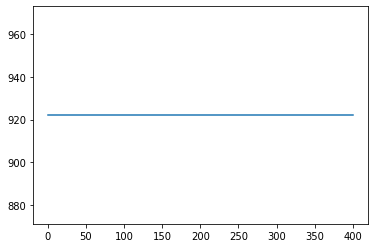

In [ ]:
test_function(num_dims=5, proxy_func=Schwefel, num_iter=400, num_first_guess=100, max_depth_model=10, splitting='random', min_samples_leaf_model=1)

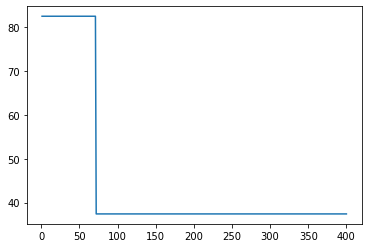

In [ ]:
test_function(num_dims=5, proxy_func=Rosenbrock, num_iter=400, num_first_guess=100, max_depth_model=10, splitting='random', min_samples_leaf_model=1)

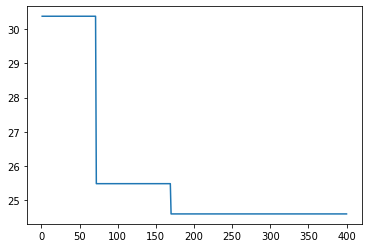

In [ ]:
test_function(num_dims=5, proxy_func=Rastrigin, num_iter=400, num_first_guess=100, max_depth_model=10, splitting='random', min_samples_leaf_model=1)

y = minimum point that we found that evaluated on test functions

x = number of iterations

In [ ]:
class Rastrigin:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.zeros(num_dims)
        self.min_y=0
        self.bounds=[-5.12,5.12]
    def eval(self,x):    
        A=10
        return A*self.num_dims + (x**2 - A * np.cos(2 * np.pi * x)).sum(axis=1)

class Schwefel:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.ones(num_dims)*420.9687
        self.min_y=0
        self.bounds=[-500,500]
    def eval(self,x):    
        return 418.92829*self.num_dims - (x * np.sin(np.abs(x)**0.5)).sum(axis=1)
class Rosenbrock:
    def __init__(self, num_dims):
        self.num_dims=num_dims
        self.min_x=np.ones(num_dims)
        self.min_y=0
        self.bounds=[-2.048,2.048]
        
    def eval(self,x):
        x_unshift=x[:,:-1]
        x_shift=x[:,1:]    
        return (100*(x_shift-x_unshift**2)**2 + (x_unshift-1)**2).sum(axis=1) 

In [ ]:
num_dims=5
num_iterations=400
num_first_guesses=100
seeds=[0,42,69]
proxies=[Rastrigin(num_dims),Schwefel(num_dims), Rosenbrock(num_dims)]

dfs, all_training_results =[],[]
for seed in seeds:
  for proxy in proxies:
        
    np.random.seed(seed)

    bound_mid=(proxy.bounds[0]+proxy.bounds[1])/2
    bound_size=proxy.bounds[1]-proxy.bounds[0]
    normalize_to_bounds=lambda x:(x-0.5+bound_mid)*bound_size

    first_guesses=normalize_to_bounds(np.random.rand(num_first_guesses, num_dims))
    first_results=proxy.eval(first_guesses)

    df=pd.DataFrame({"guesses":[first_guesses[i] for i in range(first_guesses.shape[0])],
                    "results":first_results})


    c=LinearConstraint(np.eye(num_dims), proxy.bounds[0]*np.ones(num_dims), proxy.bounds[1]*np.ones(num_dims))
    training_results=df.sort_values("results").iloc[0].to_frame().T
    model = DecisionTreeRegressor(max_depth=10, splitter='random', min_samples_leaf=2)

    for i in range (num_iterations):
        model.fit(np.vstack(df["guesses"]), np.vstack(df["results"] ))
        
        a=lambda x: model.predict(x[np.newaxis,...])   

        start_point=normalize_to_bounds(np.random.rand(num_dims))

        guess=minimize(a, start_point,constraints=c).x[np.newaxis,...]
        result=proxy.eval(guess)
        temp=pd.Series({"guesses":np.squeeze(guess),
                    "results":np.squeeze(result),
                    })
        df=df.append(temp, ignore_index=True)
        temp_training_results=df.sort_values("results").iloc[0].to_frame().T
        temp_training_results["guess_of_that_iter"]=[np.squeeze(guess)]
        temp_training_results["start_point"]=[np.squeeze(start_point)]
        temp_training_results["start_point"]=[np.squeeze(start_point)]
        temp_training_results["tree_of_that_iter"]=[np.squeeze(model.tree_)]

        training_results=training_results.append(temp_training_results , ignore_index=True)

    # plt.plot(training_results["results"][1:])
    # plt.show()
    dfs.append(df)
    all_training_results.append(training_results)

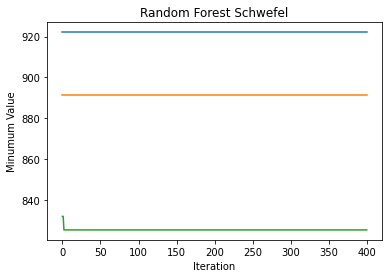

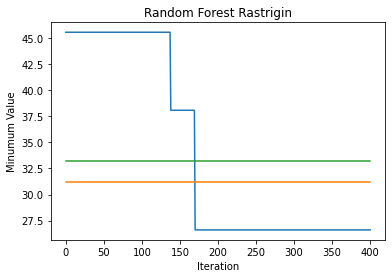

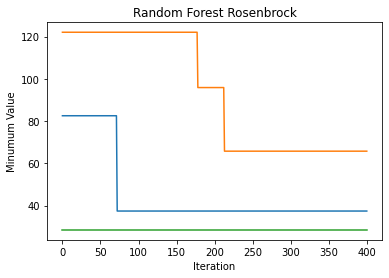

In [ ]:
plt.title("Random Forest Schwefel")
plt.plot(all_training_results[1]["results"])
plt.plot(all_training_results[4]["results"])
plt.plot(all_training_results[7]["results"])
plt.xlabel("Iteration")
plt.ylabel("Minumum Value")

plt.show()
plt.title("Random Forest Rastrigin")
plt.plot(all_training_results[0]["results"])
plt.plot(all_training_results[3]["results"])
plt.plot(all_training_results[6]["results"])
plt.xlabel("Iteration")
plt.ylabel("Minumum Value")
plt.show()

plt.title("Random Forest Rosenbrock")
plt.plot(all_training_results[2]["results"])
plt.plot(all_training_results[5]["results"])
plt.plot(all_training_results[8]["results"])
plt.xlabel("Iteration")
plt.ylabel("Minumum Value")
plt.show()

In [ ]:
count=0
for i in (0,3,6):
  count+=all_training_results[i]["results"].iloc[-1]
print(count/3)

count=0
for i in  (1,4,7):
  count+=all_training_results[i]["results"].iloc[-1]
print(count/3)

plt.show()
count=0

for i in  (2,5,8):
  count+=all_training_results[i]["results"].iloc[-1]
  # print(all_training_results[i]["results"].iloc[-1])
print(count/3)

30.337296415733203
879.6309091399215
43.873216346643865
